In [1]:
import warnings
from tqdm import tqdm
from typing import List, Tuple

import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel

from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score
warnings.simplefilter("ignore")
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\distributed\utils.py:134: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [WinError 10051] Сделана попытка выполнить операцию на сокете при отключенной сети
  % (host, default, e), RuntimeWarning)


In [2]:
data = pd.read_csv("assignment2_data/assignment_train.csv")
data.head(n=2)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Задание 1: сделать Hold-Out валидацию с разбиением, размер которого будет адеквтаным, по вашему мнению; разбиение проводить по id-транзакции (TransactionID), обучать модель градиетного бустинга любой реализации с подбором числа деревьев по early_stopping критерию до достижения сходимости. Оценить качество модели на тестовой выборке, оценить расхождение по сравнению с качеством на обучающей выборке и тестовой выборке.


In [3]:
x_train, x_test = train_test_split(
    data.drop(["TransactionID", "isFraud"], axis=1), train_size=0.75, shuffle=True, random_state=1,
)
y_train, y_test = train_test_split(
    data["isFraud"], train_size=0.75, shuffle=True, random_state=1,
)

In [4]:
numerical_features = x_train.select_dtypes(exclude=["object"])
numerical_features = numerical_features.columns.tolist()

x_train = x_train[numerical_features]
x_test = x_test[numerical_features]

print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_test.shape = {} rows, {} cols".format(*x_test.shape))

x_train.shape = 37500 rows, 378 cols
x_test.shape = 12501 rows, 378 cols


In [8]:
eval_set = [(x_test, y_test)]

In [11]:
model = xgb.XGBClassifier()
model.fit(x_train, y_train, early_stopping_rounds=10, eval_metric="logloss", eval_set=eval_set, verbose=True)

[0]	validation_0-logloss:0.45930
Will train until validation_0-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.33063
[2]	validation_0-logloss:0.25015
[3]	validation_0-logloss:0.19720
[4]	validation_0-logloss:0.16099
[5]	validation_0-logloss:0.13600
[6]	validation_0-logloss:0.11851
[7]	validation_0-logloss:0.10530
[8]	validation_0-logloss:0.09624
[9]	validation_0-logloss:0.08932
[10]	validation_0-logloss:0.08445
[11]	validation_0-logloss:0.08138
[12]	validation_0-logloss:0.07907
[13]	validation_0-logloss:0.07731
[14]	validation_0-logloss:0.07596
[15]	validation_0-logloss:0.07463
[16]	validation_0-logloss:0.07360
[17]	validation_0-logloss:0.07251
[18]	validation_0-logloss:0.07226
[19]	validation_0-logloss:0.07056
[20]	validation_0-logloss:0.07003
[21]	validation_0-logloss:0.06925
[22]	validation_0-logloss:0.06921
[23]	validation_0-logloss:0.06885
[24]	validation_0-logloss:0.06879
[25]	validation_0-logloss:0.06820
[26]	validation_0-logloss:0.06783
[27]	validation_0-loglos

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints='',
       learning_rate=0.300000012, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=nan, monotone_constraints='()',
       n_estimators=100, n_jobs=0, num_parallel_tree=1,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
       validate_parameters=1, verbosity=None)

In [ ]:
# недообучение -
# переобучение +
# все ок =

In [12]:
train_score = r2_score(y_train, model.predict(x_train))
test_score = r2_score(y_test, model.predict(x_test))

print(f"Train-score: {round(train_score, 3)}, Test-score: {round(test_score, 3)}")

Train-score: 0.787, Test-score: 0.4


Задание 2: сделать Hold-Out валидацию с разбиением на 3 выборки, разбиение проводить по id-транзакции (TransactionID), размер каждой выборки подобрать самостоятельно. Повторить процедуру из п.1.

In [13]:
x_train, x_valid = train_test_split(
    data.drop(["TransactionID", "isFraud"], axis=1), train_size=0.7, shuffle=True, random_state=1,
)
y_train, y_valid = train_test_split(
    data["isFraud"], train_size=0.7, shuffle=True, random_state=1,
)

x_train = x_train[numerical_features]
x_valid = x_valid[numerical_features]

x_valid, x_test = train_test_split(
    x_valid, train_size=0.7, shuffle=True, random_state=27
)
y_valid, y_test = train_test_split(
    y_valid, train_size=0.7, shuffle=True, random_state=27
)

print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))
print("x_test.shape = {} rows, {} cols".format(*x_test.shape))

x_train.shape = 35000 rows, 378 cols
x_valid.shape = 10500 rows, 378 cols
x_test.shape = 4501 rows, 378 cols


In [14]:
model = xgb.XGBClassifier()
model.fit(x_train, y_train, early_stopping_rounds=10, eval_metric="logloss", eval_set=eval_set, verbose=True)

[0]	validation_0-logloss:0.45904
Will train until validation_0-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.33068
[2]	validation_0-logloss:0.25040
[3]	validation_0-logloss:0.19737
[4]	validation_0-logloss:0.16144
[5]	validation_0-logloss:0.13621
[6]	validation_0-logloss:0.11859
[7]	validation_0-logloss:0.10575
[8]	validation_0-logloss:0.09673
[9]	validation_0-logloss:0.08941
[10]	validation_0-logloss:0.08471
[11]	validation_0-logloss:0.08121
[12]	validation_0-logloss:0.07848
[13]	validation_0-logloss:0.07687
[14]	validation_0-logloss:0.07519
[15]	validation_0-logloss:0.07368
[16]	validation_0-logloss:0.07273
[17]	validation_0-logloss:0.07241
[18]	validation_0-logloss:0.07110
[19]	validation_0-logloss:0.07097
[20]	validation_0-logloss:0.07052
[21]	validation_0-logloss:0.07043
[22]	validation_0-logloss:0.06987
[23]	validation_0-logloss:0.06874
[24]	validation_0-logloss:0.06842
[25]	validation_0-logloss:0.06767
[26]	validation_0-logloss:0.06738
[27]	validation_0-loglos

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints='',
       learning_rate=0.300000012, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=nan, monotone_constraints='()',
       n_estimators=100, n_jobs=0, num_parallel_tree=1,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
       validate_parameters=1, verbosity=None)

In [15]:
train_score = r2_score(y_train, model.predict(x_train))
valid_score = r2_score(y_valid, model.predict(x_valid))
test_score = r2_score(y_test, model.predict(x_test))

print(f"Train-score: {round(train_score, 3)}, Valid-score: {round(valid_score, 3)}, Test-score: {round(test_score, 3)}")

Train-score: 0.724, Valid-score: 0.382, Test-score: 0.366


Задание 3: построить доверительный интервал на данных из п.2 на основе бутстреп выборок, оценить качество модели на тестовом выборке относительно полученного доверительного интервала. Сделать выводы.


In [16]:
def create_bootstrap_samples(data: np.array, n_samples: int = 1000) -> np.array:
    """
    Создание бутстреп-выборок.

    Parameters
    ----------
    data: np.array
        Исходная выборка, которая будет использоваться для
        создания бутстреп выборок.

    n_samples: int, optional, default = 1000
        Количество создаваемых бутстреп выборок.
        Опциональный параметр, по умолчанию, равен 1000.

    Returns
    -------
    bootstrap_idx: np.array
        Матрица индексов, для создания бутстреп выборок.

    """
    bootstrap_idx = np.random.randint(
        low=0, high=len(data), size=(n_samples, len(data))
    )
    return bootstrap_idx


def create_bootstrap_metrics(y_true: np.array,
                             y_pred: np.array,
                             metric: callable,
                             n_samlpes: int = 1000) -> List[float]:
    """
    Вычисление бутстреп оценок.

    Parameters
    ----------
    y_true: np.array
        Вектор целевой переменной.

    y_pred: np.array
        Вектор прогнозов.

    metric: callable
        Функция для вычисления метрики.
        Функция должна принимать 2 аргумента: y_true, y_pred.

    n_samples: int, optional, default = 1000
        Количество создаваемых бутстреп выборок.
        Опциональный параметр, по умолчанию, равен 1000.

    Returns
    -------
    bootstrap_metrics: List[float]
        Список со значениями метрики качества на каждой бустреп выборке.

    """
    scores = []

    if isinstance(y_true, pd.Series):
        y_true = y_true.values

    bootstrap_idx = create_bootstrap_samples(y_true)
    for idx in bootstrap_idx:
        y_true_bootstrap = y_true[idx]
        y_pred_bootstrap = y_pred[idx]

        score = metric(y_true_bootstrap, y_pred_bootstrap)
        scores.append(score)

    return scores


def calculate_confidence_interval(scores: list, conf_interval: float = 0.95) -> Tuple[float]:
    """
    Вычисление доверительного интервала.

    Parameters
    ----------
    scores: List[float / int]
        Список с оценками изучаемой величины.

    conf_interval: float, optional, default = 0.95
        Уровень доверия для построения интервала.
        Опциональный параметр, по умолчанию, равен 0.95.

    Returns
    -------
    conf_interval: Tuple[float]
        Кортеж с границами доверительного интервала.

    """
    left_bound = np.percentile(
        scores, ((1 - conf_interval) / 2) * 100
    )
    right_bound = np.percentile(
        scores, (conf_interval + ((1 - conf_interval) / 2)) * 100
    )

    return left_bound, right_bound

In [17]:
np.random.seed(27)
scores = create_bootstrap_metrics(y_test, model.predict(x_test), r2_score)

calculate_confidence_interval(scores)

(0.2731376866012037, 0.4689299846340158)

In [ ]:
# Hold-Out
# оценил качество на HO
# доверительный интервал на HO
# отправляю решение на LB
# если качество на public LB лежит внутри CI -> валидация хорошая

Text(0.5, 0, 'sampel number')

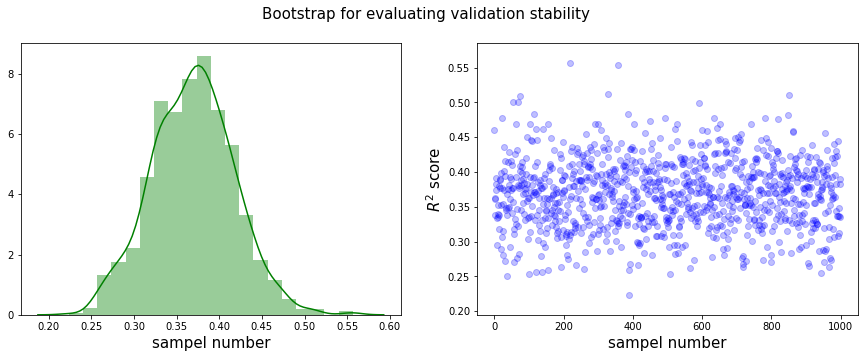

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plt.suptitle("Bootstrap for evaluating validation stability", size=15)
axes[1].scatter(range(len(scores)), scores, alpha=0.25, color="blue")
axes[1].set_xlabel("sampel number", size=15)
axes[1].set_ylabel("$R^2$ score", size=15)

sns.distplot(scores, ax=axes[0], color="green", bins=20)
axes[0].set_xlabel("sampel number", size=15)

Вывод: скор на тестовой выборке вошел в доверительный интервал. 

Задание 4: выполнить Adversarial Validation на основе данных из обучения / теста, подобрать объема из обучающей выборки, которые сильно похожи на объекты из тестовой выборки, и использовать их в качестве валидационного набора. Сделать выводы о полученных результатах.


## Что делать, если распределение на train / test разное

__Adversarial validation__

In [21]:
from sklearn.metrics import roc_auc_score

In [26]:
x_train, x_test = train_test_split(
    data.drop(["TransactionID", "isFraud"], axis=1), train_size=0.75, shuffle=True, random_state=1,
)
y_train, y_test = train_test_split(
    data["isFraud"], train_size=0.75, shuffle=True, random_state=1,
)

In [28]:
x_adv = pd.concat([
    x_train, x_test], axis=0)
y_adv = np.hstack((np.zeros(x_train.shape[0]), np.ones(x_test.shape[0])))
assert x_adv.shape[0] == y_adv.shape[0]

In [29]:
model = xgb.XGBClassifier(n_estimators=25)
model.fit(x_adv[numerical_features], y_adv)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints='',
       learning_rate=0.300000012, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=nan, monotone_constraints='()',
       n_estimators=25, n_jobs=0, num_parallel_tree=1,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
       validate_parameters=1, verbosity=None)

In [30]:
y_pred = model.predict_proba(x_train[numerical_features])
#roc_auc_score()

In [31]:
pd.cut(
    y_pred[:, 1], bins=np.arange(0, 1.01, 0.1)
).value_counts().sort_index()

(0.0, 0.1]       81
(0.1, 0.2]     3069
(0.2, 0.3]    33293
(0.3, 0.4]      991
(0.4, 0.5]       60
(0.5, 0.6]        6
(0.6, 0.7]        0
(0.7, 0.8]        0
(0.8, 0.9]        0
(0.9, 1.0]        0
dtype: int64

In [36]:
y_pred

array([[0.74110067, 0.2588993 ],
       [0.76054615, 0.23945384],
       [0.8854348 , 0.11456522],
       ...,
       [0.7516727 , 0.24832731],
       [0.7190107 , 0.2809893 ],
       [0.73706377, 0.26293623]], dtype=float32)

In [48]:
x_train['pred'].apply(y_pred)
x_valid = x_train[x_train['pred'] > 0.3]     

KeyError: 'pred'

Задание 5: сделать KFold / StratifiedKFold валидацию (на ваше усмотрение), оценить получаемые качество и разброс по метрике качества. Сделать выводы об устойчивости кросс-валидации, сходимости оценки на кросс-валидации и отложенном наборе данных;


In [53]:
cv = cross_val_score(
    estimator=model,
    X=data[numerical_features],
    y=data["isFraud"],
    scoring="r2",
    cv=5
)

print(f"CV-results: {round(np.mean(cv), 4)} +/- {round(np.std(cv), 3)}")

CV-results: 0.1652 +/- 0.082


In [51]:
def make_cross_validation(X: pd.DataFrame,
                          y: pd.Series,
                          estimator: object,
                          metric: callable,
                          cv_strategy):
    """
    Кросс-валидация.

    Parameters
    ----------
    X: pd.DataFrame
        Матрица признаков.

    y: pd.Series
        Вектор целевой переменной.

    estimator: callable
        Объект модели для обучения.

    metric: callable
        Метрика для оценки качества решения.
        Ожидается, что на вход будет передана функция,
        которая принимает 2 аргумента: y_true, y_pred.

    cv_strategy: cross-validation generator
        Объект для описания стратегии кросс-валидации.
        Ожидается, что на вход будет передан объект типа
        KFold или StratifiedKFold.

    Returns
    -------
    oof_score: float
        Значение метрики качества на OOF-прогнозах.

    fold_train_scores: List[float]
        Значение метрики качества на каждом обучающем датасете кросс-валидации.

    fold_valid_scores: List[float]
        Значение метрики качества на каждом валидационном датасете кросс-валидации.

    oof_predictions: np.array
        Прогнозы на OOF.

    """
    estimators, fold_train_scores, fold_valid_scores = [], [], []
    oof_predictions = np.zeros(X.shape[0])

    for fold_number, (train_idx, valid_idx) in enumerate(cv_strategy.split(X, y)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y.loc[train_idx], y.loc[valid_idx]

        estimator.fit(x_train, y_train)
        y_train_pred = estimator.predict(x_train)
        y_valid_pred = estimator.predict(x_valid)

        fold_train_scores.append(metric(y_train, y_train_pred))
        fold_valid_scores.append(metric(y_valid, y_valid_pred))
        oof_predictions[valid_idx] = y_valid_pred

        msg = (
            f"Fold: {fold_number+1}, train-observations = {len(train_idx)}, "
            f"valid-observations = {len(valid_idx)}\n"
            f"train-score = {round(fold_train_scores[fold_number], 4)}, "
            f"valid-score = {round(fold_valid_scores[fold_number], 4)}" 
        )
        print(msg)
        print("="*69)
        estimators.append(estimator)

    oof_score = metric(y, oof_predictions)
    print(f"CV-results train: {round(np.mean(fold_train_scores), 4)} +/- {round(np.std(fold_train_scores), 3)}")
    print(f"CV-results valid: {round(np.mean(fold_valid_scores), 4)} +/- {round(np.std(fold_valid_scores), 3)}")
    print(f"OOF-score = {round(oof_score, 4)}")

    return estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions

In [54]:
cv_strategy = KFold(n_splits=5, random_state=1)

estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions = make_cross_validation(
    data[numerical_features], data["isFraud"], model, metric=r2_score, cv_strategy=cv_strategy
)

Fold: 1, train-observations = 40000, valid-observations = 10001
train-score = 0.5312, valid-score = 0.1705
Fold: 2, train-observations = 40001, valid-observations = 10000
train-score = 0.5116, valid-score = 0.1845
Fold: 3, train-observations = 40001, valid-observations = 10000
train-score = 0.4995, valid-score = 0.2633
Fold: 4, train-observations = 40001, valid-observations = 10000
train-score = 0.5002, valid-score = 0.1901
Fold: 5, train-observations = 40001, valid-observations = 10000
train-score = 0.4987, valid-score = 0.1697
CV-results train: 0.5082 +/- 0.012
CV-results valid: 0.1956 +/- 0.035
OOF-score = 0.1978


Задание 6 * (опциональное): сделать Hold-Out валидацию по времени (TransactionDT), повторить процедуры из п.1 / п.2 (на ваш выбор). Построить доверительный интервал, сравнить качество на тестовой выборке с полученным доверительным интервалом. Сделать выводы.


Можно просто не перемешивать, данные в наборе изначально упорядочены по времени.

In [3]:
x_train, x_test = train_test_split(
    data.drop(["TransactionID", "isFraud"], axis=1), train_size=0.75, shuffle=False, random_state=1,
)
y_train, y_test = train_test_split(
    data["isFraud"], train_size=0.75, shuffle=True, random_state=1,
)

In [4]:
numerical_features = x_train.select_dtypes(exclude=["object"])
numerical_features = numerical_features.columns.tolist()

x_train = x_train[numerical_features]
x_test = x_test[numerical_features]

print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_test.shape = {} rows, {} cols".format(*x_test.shape))

x_train.shape = 37500 rows, 378 cols
x_test.shape = 12501 rows, 378 cols


In [5]:
eval_set = [(x_test, y_test)]

In [6]:
model = xgb.XGBClassifier()
model.fit(x_train, y_train, early_stopping_rounds=10, eval_metric="logloss", eval_set=eval_set, verbose=True)

[0]	validation_0-logloss:0.46495
Will train until validation_0-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.34055
[2]	validation_0-logloss:0.26424
[3]	validation_0-logloss:0.21525
[4]	validation_0-logloss:0.18338
[5]	validation_0-logloss:0.16239
[6]	validation_0-logloss:0.14864
[7]	validation_0-logloss:0.14086
[8]	validation_0-logloss:0.13501
[9]	validation_0-logloss:0.13145
[10]	validation_0-logloss:0.12984
[11]	validation_0-logloss:0.12871
[12]	validation_0-logloss:0.12777
[13]	validation_0-logloss:0.12763
[14]	validation_0-logloss:0.12725
[15]	validation_0-logloss:0.12724
[16]	validation_0-logloss:0.12737
[17]	validation_0-logloss:0.12734
[18]	validation_0-logloss:0.12745
[19]	validation_0-logloss:0.12744
[20]	validation_0-logloss:0.12747
[21]	validation_0-logloss:0.12778
[22]	validation_0-logloss:0.12781
[23]	validation_0-logloss:0.12788
[24]	validation_0-logloss:0.12806
[25]	validation_0-logloss:0.12890
Stopping. Best iteration:
[15]	validation_0-logloss:0.1272

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints='',
       learning_rate=0.300000012, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=nan, monotone_constraints='()',
       n_estimators=100, n_jobs=0, num_parallel_tree=1,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
       validate_parameters=1, verbosity=None)

In [7]:
# недообучение -
# переобучение +
# все ок =

In [8]:
train_score = r2_score(y_train, model.predict(x_train))
test_score = r2_score(y_test, model.predict(x_test))

print(f"Train-score: {round(train_score, 3)}, Test-score: {round(test_score, 3)}")

Train-score: -0.027, Test-score: -0.028
